
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Détection de race de chien sur tous le dataset
        </h1>
    </div>
</div>

L'objectif de ce Notebook est d utiliser le meilleur modele ici Xception et de l entrainer sur tous notre dataset 
Les contraintes ici vont principalement etre d ordre pratique, en effet l entrainement d un modele de deep learning est tres couteux en ressources, et les techniques utiliser precedement ne pourrons pas etre appliquer a cause de la memoire disponible sur l ordinateur.

Pour cela keras nous propose des alternatives afin de combiner memoire/performances


<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Sommaire
        </h1>
    </div>
</div>

- **[Preparation du dataset](#pre)**

- **[entrainement du modele](#en)**

- **[Xception fine tuning](#fi)**

- **[Application](#ap)**



In [ ]:
from google.colab import drive
drive.mount('/content/ShardDrives/', force_remount=True)

Mounted at /content/ShardDrives/


In [ ]:
!nvidia-smi

Thu Apr 14 11:39:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#preparation du dataset
# !mkdir /content/Stanford_Dogs_Dataset/

In [4]:
# !tar -xf /media/ismail/Elements/formation/projet7/standford_dog_dataset2/annotation.tar --directory /media/ismail/Elements/formation/projet7/standford_dog_dataset2

In [5]:
# !tar -xf /media/ismail/Elements/formation/projet7/standford_dog_dataset2/images.tar --directory /media/ismail/Elements/formation/projet7/standford_dog_dataset2/

In [6]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgmp
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tqdm import tqdm
import keras_tuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [7]:
print(tf.__version__)

2.8.0


In [8]:
# import utils own functions
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/media/ismail/Elements/formation/projet7/utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

test GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

<a name='pre'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Preparation du dataset
        </h1>
    </div>
</div>

Pour palier au manque de memoire durant l entrainement de toute les races, nous avons traiter les images (Filtre non-local means, histogramme, resizing...) et les avons repartis dans un jeu train/test 

In [10]:
annotations_directory = '/media/ismail/Elements/formation/projet7/standford_dog_dataset2/Annotation' 
images_directory = '/media/ismail/Elements/formation/projet7/standford_dog_dataset2/Images'
utils.rename_directory(images_directory,annotations_directory)

True

In [11]:
race_list = os.listdir(images_directory)
annotation_list = os.listdir(annotations_directory)

In [13]:
print("Nombre de races dans le dataset:", (len(race_list)))
nb_photos_pear_races = [len(os.listdir(images_directory + "/" + name))for name in race_list]

Nombre de races dans le dataset: 120


In [14]:
df = pd.DataFrame(
    index=race_list,
    data=nb_photos_pear_races,
    columns=["nb_photos"])

df

,nb_photos
affenpinscher,150
Afghan_hound,239
African_hunting_dog,169
Airedale,202
American_Staffordshire_terrier,164
...,...
Rottweiler,152
Saint_Bernard,170
Saluki,200
Samoyed,218


In [15]:
df.nb_photos.sum()

20580

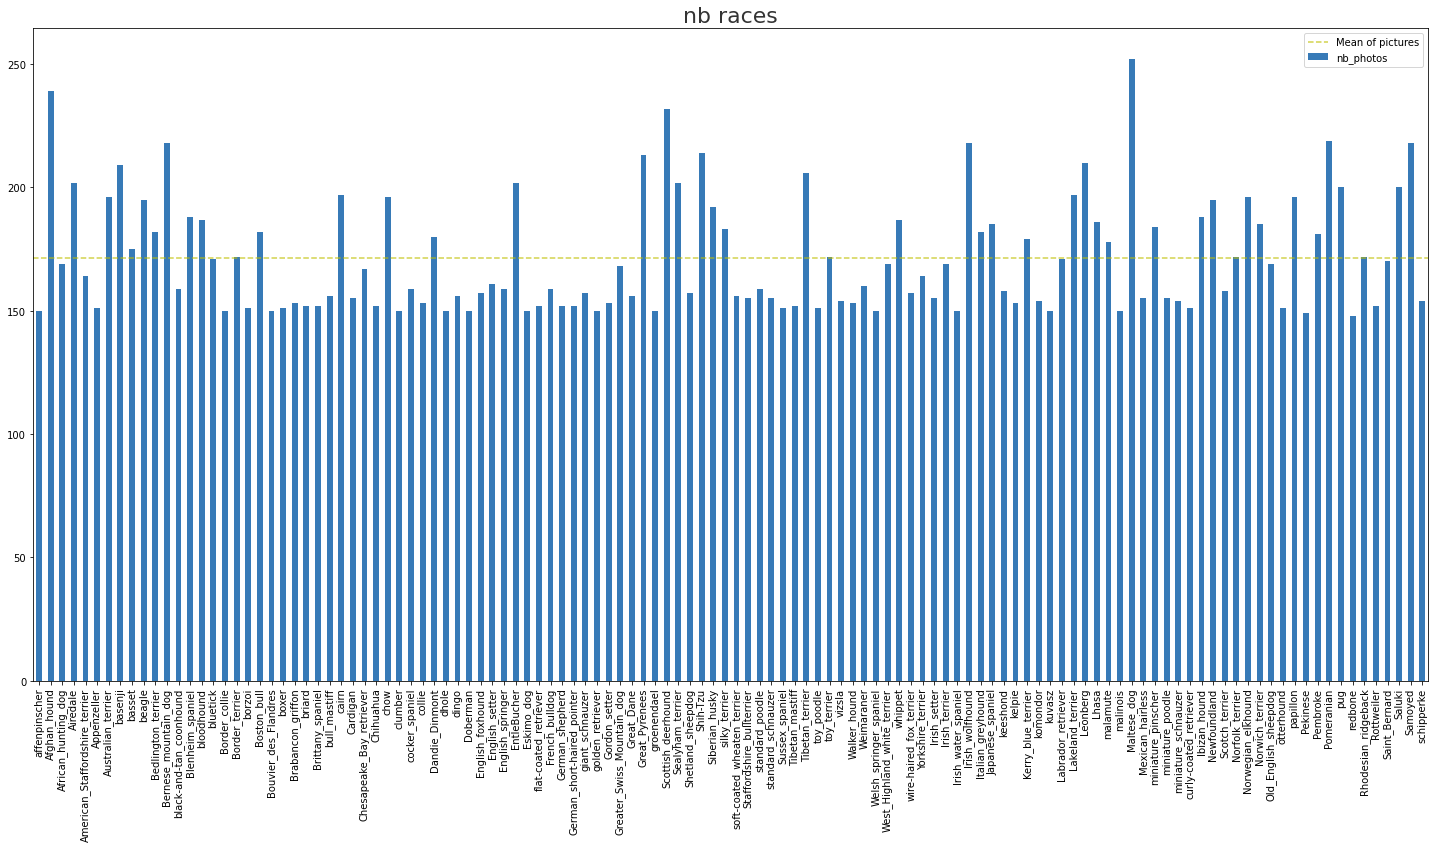

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df.plot(kind="bar",color='#377AB7',
               legend=False,
               ax=ax)
ax.axhline(df["nb_photos"].mean(),
           color='y', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("nb races",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

/media/ismail/Elements/formation/projet7/utils.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_sample/num_sample+1, num_sample, i+1)


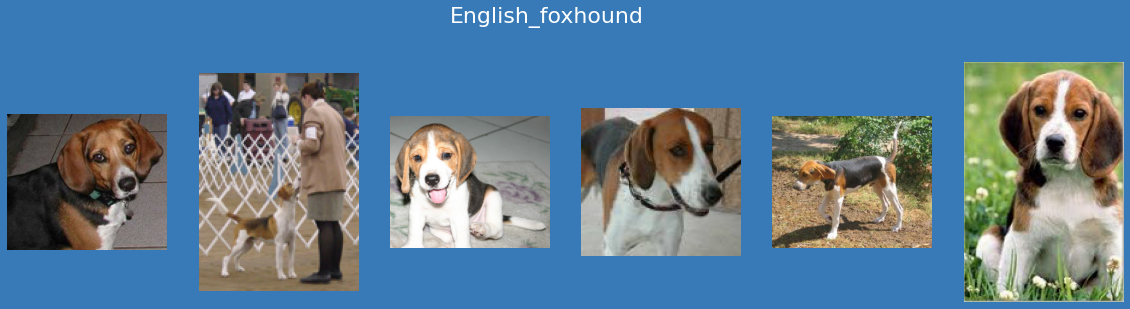

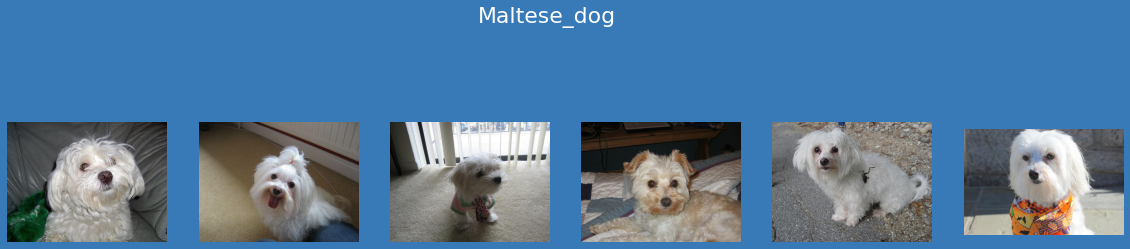

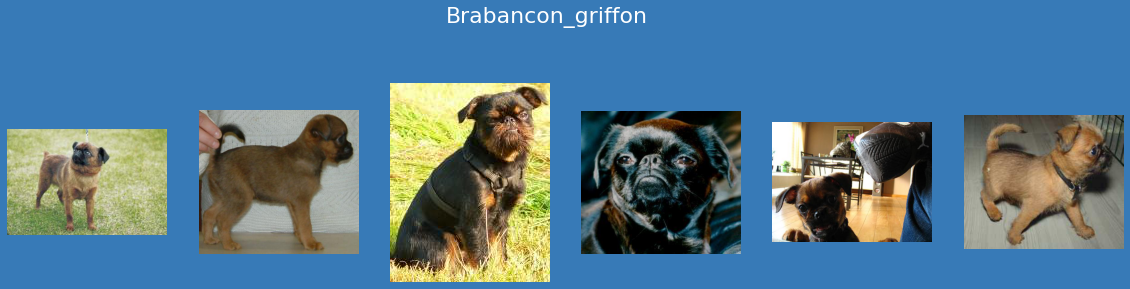

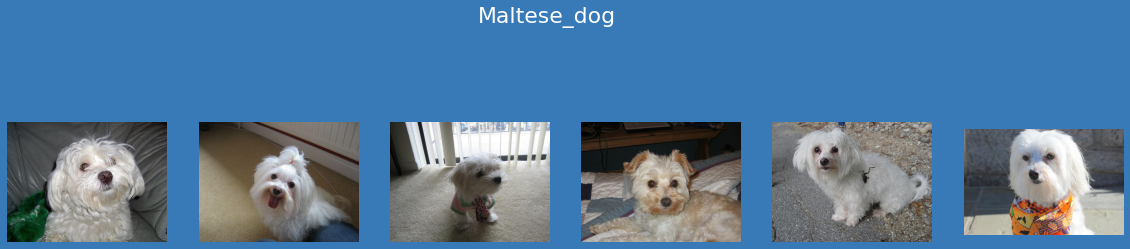

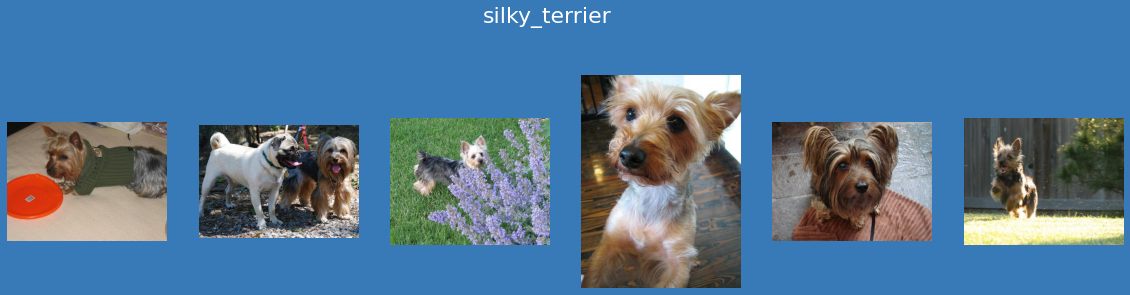

In [20]:
for i in np.random.randint(0, len(race_list), size=5):
    utils.show_images_from_directory(images_directory, race_list[i], 6)

In [14]:
train_dir = '../stanford_dog_dataset_tt/cropped/train/'
test_dir = '../stanford_dog_dataset_tt/cropped/test/'
utils.rename_directory(train_dir,test_dir)

True

In [17]:
races_list = os.listdir(train_dir)
print(len(races_list))
races_list

120


['affenpinscher',
 'Afghan_hound',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller',
 'Australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'Bedlington_terrier',
 'Bernese_mountain_dog',
 'black-and-tan_coonhound',
 'Blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'Border_collie',
 'Border_terrier',
 'borzoi',
 'Boston_bull',
 'Bouvier_des_Flandres',
 'boxer',
 'Brabancon_griffon',
 'briard',
 'Brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'Cardigan',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'Rottweiler',
 'Saint_Bernard',
 'Saluki',
 'Samoyed',
 'schipperke',
 'Scotch_terrier',
 'Scottish_deerhound',
 'Sealyham_terrier',
 'Shetland_sheepdog',
 'Shih-Tzu',
 'Siberian_husky',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'Staffordshire_bullterrier',
 'standard_poodle',
 'standard_schnauzer',
 'Sussex_spaniel',
 'Tibetan_mastiff',
 'Tibetan_terrier',
 'toy_poodle',
 'toy_terrier',
 'vizsl

Nous avons spliter notre dataset dans deux repertoires l un pour l entrainement et l autre pour les tests

Pour palier au manque de memoire , nous allons utiliser la methode flow_from_directory, qui va lire au fur et a mesure notre dataset sur le disque dur et effectuer lui meme a la volees les data augmentation

In [180]:
# Training generator
datagen = ImageDataGenerator( 
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=40,
    zoom_range = 0.1,
    rescale=1./255,
    validation_split=0.33)
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="training"
)

Found 8040 images belonging to 120 classes.


In [181]:
# Valid generator

valid_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="validation"
)

# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 3960 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


In [106]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
print(test_steps_per_epoch)

125 61
269


In [6]:
# Metrics have been removed from Keras core. We need to calculate them manually
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [123]:
def plot_history_scores(dict_history,modele_name, first_score, second_score):
  fig = plt.figure(figsize=(25,10))
  # summarize history for accuracy
  plt.subplot(1, 2, 1)
  plt.plot(dict_history[first_score])
  plt.plot(dict_history['val_' + first_score],
            linestyle='--', color="red")
  plt.title(modele_name+' '+ first_score, fontsize=18)
  plt.ylabel(first_score)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(dict_history[second_score])
  plt.plot(dict_history['val_' + second_score],
            linestyle='--', color="red")
  plt.title(modele_name +' '+ second_score, fontsize=18)
  plt.ylabel(second_score)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
print(tf.__version__)

2.8.0


recuperation de nos hyperparametres de nos modeles precedent

In [124]:
import hickle as hkl
best_hyperparameters = hkl.load('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/best_hyperparameters.hkl' )


<a name='en'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          entrainement du modele
        </h1>
    </div>
</div>

Creation d un reseau de neurone Xception 

gel de nos couches et ajout d une activation softmax sur nos 120 classes (et dropout)

In [125]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(299,299,3))
xception_model.summary()

output = xception_model.output
output = Dense(128, activation='relu')(output)
output = Dropout(0.2)(output)
# Output : new classifier
predictions = Dense(120, activation='softmax')(output)


for i, layer in enumerate(xception_model.layers):
  layer.trainable = False 
  # layer.trainable = False if i < nb_layers else True     
# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=["accuracy", f1_m])    


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

Les temps d entrainement peuvent etre relativement long et plusieurs autres problemes techniques de mise en place du modele peuvent rendre le developpement laborieux

Heureusement le framework keras permet de faire des callback , le principe reside dans le declenchement d evenement, a chaque evenement qui nous parait interessant , nous pouvons effectuer des actions pendant l entrainement, ici nous en avons defini deux :

    - early stopping : si pendant x epochs nos metriques ne s ameliore pas, nous l arretons plus tot
    
    - modelcheckpoint : nous sauvegardons le modele entre x epochs, ce qui nous permet de reprendre l entrainement la ou on la laisser

In [127]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)


SAVE_PERIOD = 5

# Create a callback that saves the model's weights every 10 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/', 
    verbose=1, 
    save_weights_only=True,
    save_freq= int(SAVE_PERIOD * test_steps_per_epoch))


history_xcept = my_xcept_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    verbose=2,
                    callbacks=[early_stopping],
)

Epoch 1/20
125/125 - 211s - loss: 2.4389 - accuracy: 0.5150 - f1_m: 0.2552 - val_loss: 0.8820 - val_accuracy: 0.7856 - val_f1_m: 0.7206 - 211s/epoch - 2s/step
Epoch 2/20
125/125 - 206s - loss: 0.8578 - accuracy: 0.7625 - f1_m: 0.7372 - val_loss: 0.6857 - val_accuracy: 0.8028 - val_f1_m: 0.7888 - 206s/epoch - 2s/step
Epoch 3/20
125/125 - 207s - loss: 0.6989 - accuracy: 0.7964 - f1_m: 0.7868 - val_loss: 0.6312 - val_accuracy: 0.8140 - val_f1_m: 0.8095 - 207s/epoch - 2s/step
Epoch 4/20
125/125 - 206s - loss: 0.6295 - accuracy: 0.8102 - f1_m: 0.8068 - val_loss: 0.6083 - val_accuracy: 0.8176 - val_f1_m: 0.8135 - 206s/epoch - 2s/step
Epoch 5/20
125/125 - 206s - loss: 0.5836 - accuracy: 0.8233 - f1_m: 0.8191 - val_loss: 0.6003 - val_accuracy: 0.8145 - val_f1_m: 0.8161 - 206s/epoch - 2s/step
Epoch 6/20
125/125 - 205s - loss: 0.5396 - accuracy: 0.8346 - f1_m: 0.8319 - val_loss: 0.5782 - val_accuracy: 0.8179 - val_f1_m: 0.8224 - 205s/epoch - 2s/step
Epoch 7/20
125/125 - 206s - loss: 0.4989 - acc

In [128]:
my_xcept_model.save('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_xcept_model_all.h5')

# my_xcept_model = load_model('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_xcept_model_all.h5', custom_objects={"f1_m": f1_m})

In [129]:
import json
history_xcept_dict = history_xcept.history
# Save it under the form of a json file
json.dump(history_xcept_dict, open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_xcept_dict_all', 'w'))
history_xcept_dict = json.load(open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_xcept_dict_all', 'r'))

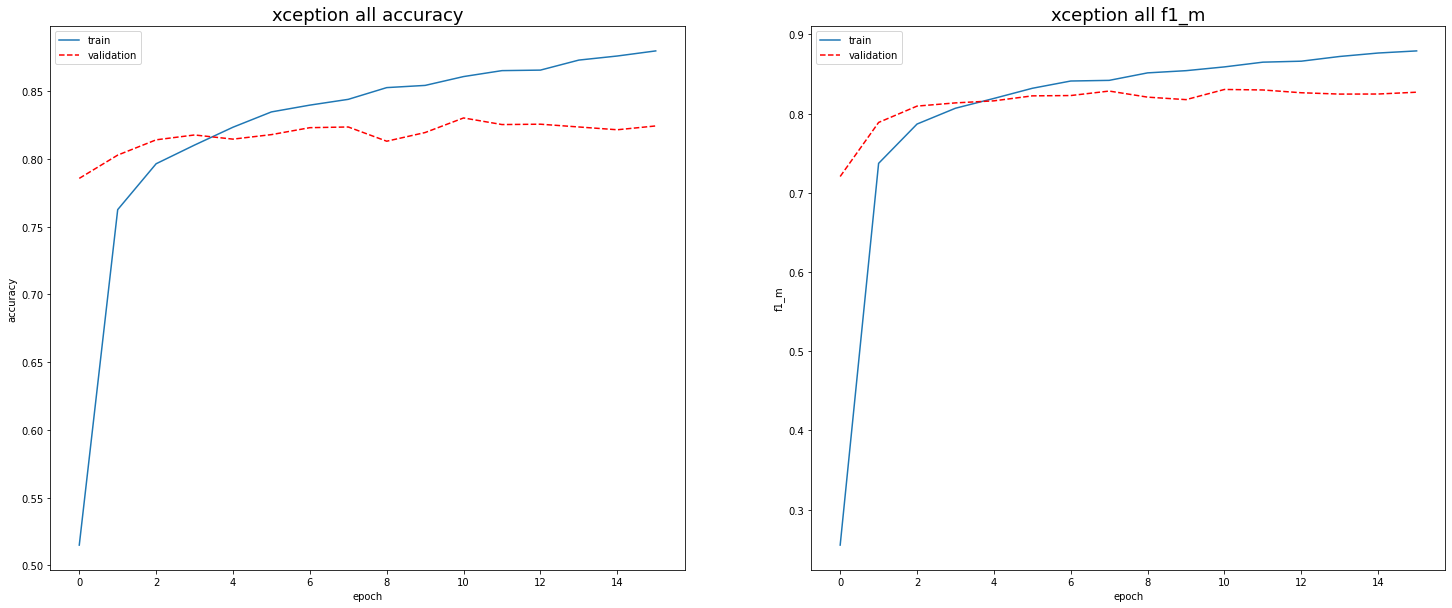

In [130]:
plot_history_scores(
    dict_history = history_xcept_dict, 
    modele_name='xception all',
    first_score = "accuracy", 
    second_score = "f1_m")

- La matrice de confusion et le rapport de classification nous indiquent que les résultats sont satisfaisants.
- l'Accuracy globale sur le jeu de test est de 0.85 et la matrice présente bien les couples predict / true majoritaires en diagonale

**les prédictions sont bonnes dans la plupart des cas**

In [132]:
predictions = my_xcept_model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

                                precision    recall  f1-score   support

                  Afghan_hound       1.00      0.99      1.00       139
           African_hunting_dog       1.00      0.99      0.99        69
                      Airedale       0.94      0.83      0.89       102
American_Staffordshire_terrier       0.69      0.80      0.74        64
                   Appenzeller       0.70      0.63      0.66        51
            Australian_terrier       0.92      0.84      0.88        96
            Bedlington_terrier       1.00      0.99      0.99        82
          Bernese_mountain_dog       0.96      0.87      0.92       118
              Blenheim_spaniel       0.98      0.97      0.97        88
                 Border_collie       0.72      0.78      0.75        50
                Border_terrier       0.92      0.94      0.93        72
                   Boston_bull       0.99      0.98      0.98        82
          Bouvier_des_Flandres       0.83      0.88      0.85  

In [140]:
predicted_classes

array([  0,   0,   0, ..., 119, 119, 119])

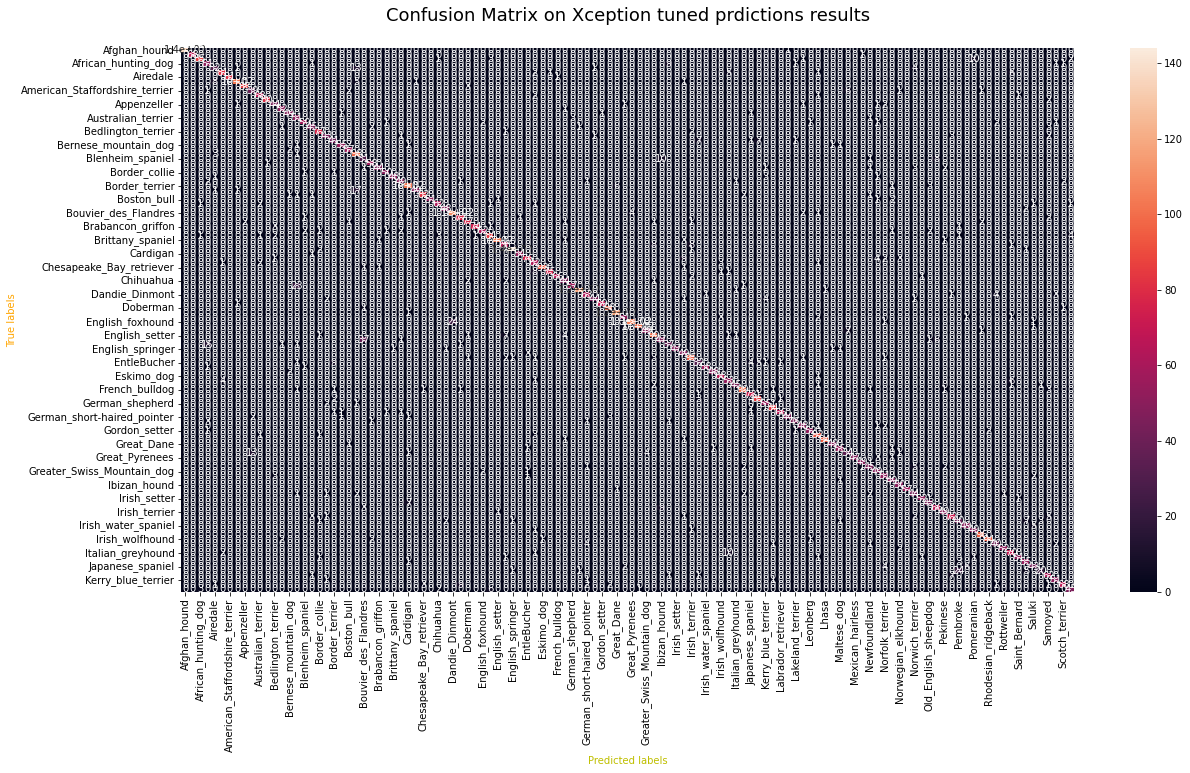

In [134]:
fig = plt.figure(figsize=(20,10))
# Confusion Matrix
cf_matrix = confusion_matrix(true_classes, predicted_classes)
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("Predicted labels", color="y")
ax.set_ylabel("True labels", color="orange")
ax.xaxis.set_ticklabels(class_labels, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,
                        rotation='horizontal')
plt.title("Confusion Matrix on Xception tuned prdictions results\n",
          fontsize=18)
plt.show()

In [142]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_classes]

In [177]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.sample(30)

,Filename,Predictions
4047,Pomeranian/n02112018_3064.jpg,Pomeranian
1679,EntleBucher/n02108000_2027.jpg,EntleBucher
6758,curly-coated_retriever/n02099429_1150.jpg,curly-coated_retriever
2273,Ibizan_hound/n02091244_2038.jpg,Ibizan_hound
307,Airedale/n02096051_9581.jpg,otterhound
7309,kuvasz/n02104029_3207.jpg,kuvasz
1590,English_springer/n02102040_1055.jpg,English_springer
2197,Greater_Swiss_Mountain_dog/n02107574_1437.jpg,Greater_Swiss_Mountain_dog
7644,miniature_schnauzer/n02097047_5253.jpg,miniature_schnauzer
1896,German_shepherd/n02106662_3116.jpg,German_shepherd


In [139]:
true_classes[predicted_classes]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [194]:
len(my_xcept_model.layers)

136


<a name='ap'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
         Application
        </h1>
    </div>
</div>

Un programme Python qui prend une image (array) en entrée et retourne la race la plus probable du chien présent sur l'image.

Un programme python est disponible <code>chien_detect.py</code>

voici le ligne de commande a lancer

<code>python chien_detect.py predict_image 'path_image'</code>

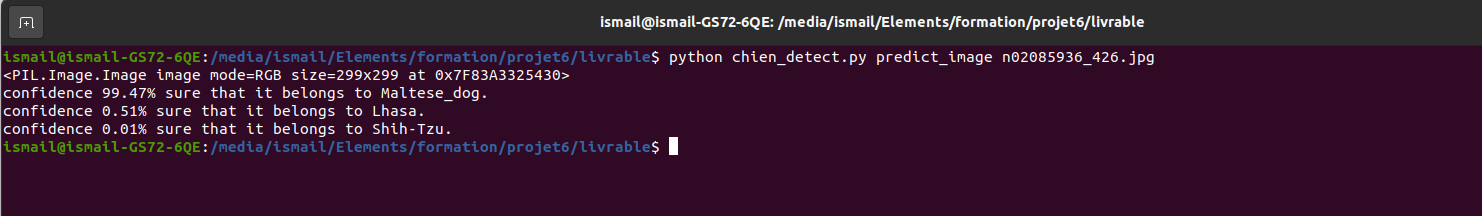

Une application web flask est disponible sur stackoverflow

https://github.com/ismailazdad/dogs_classification

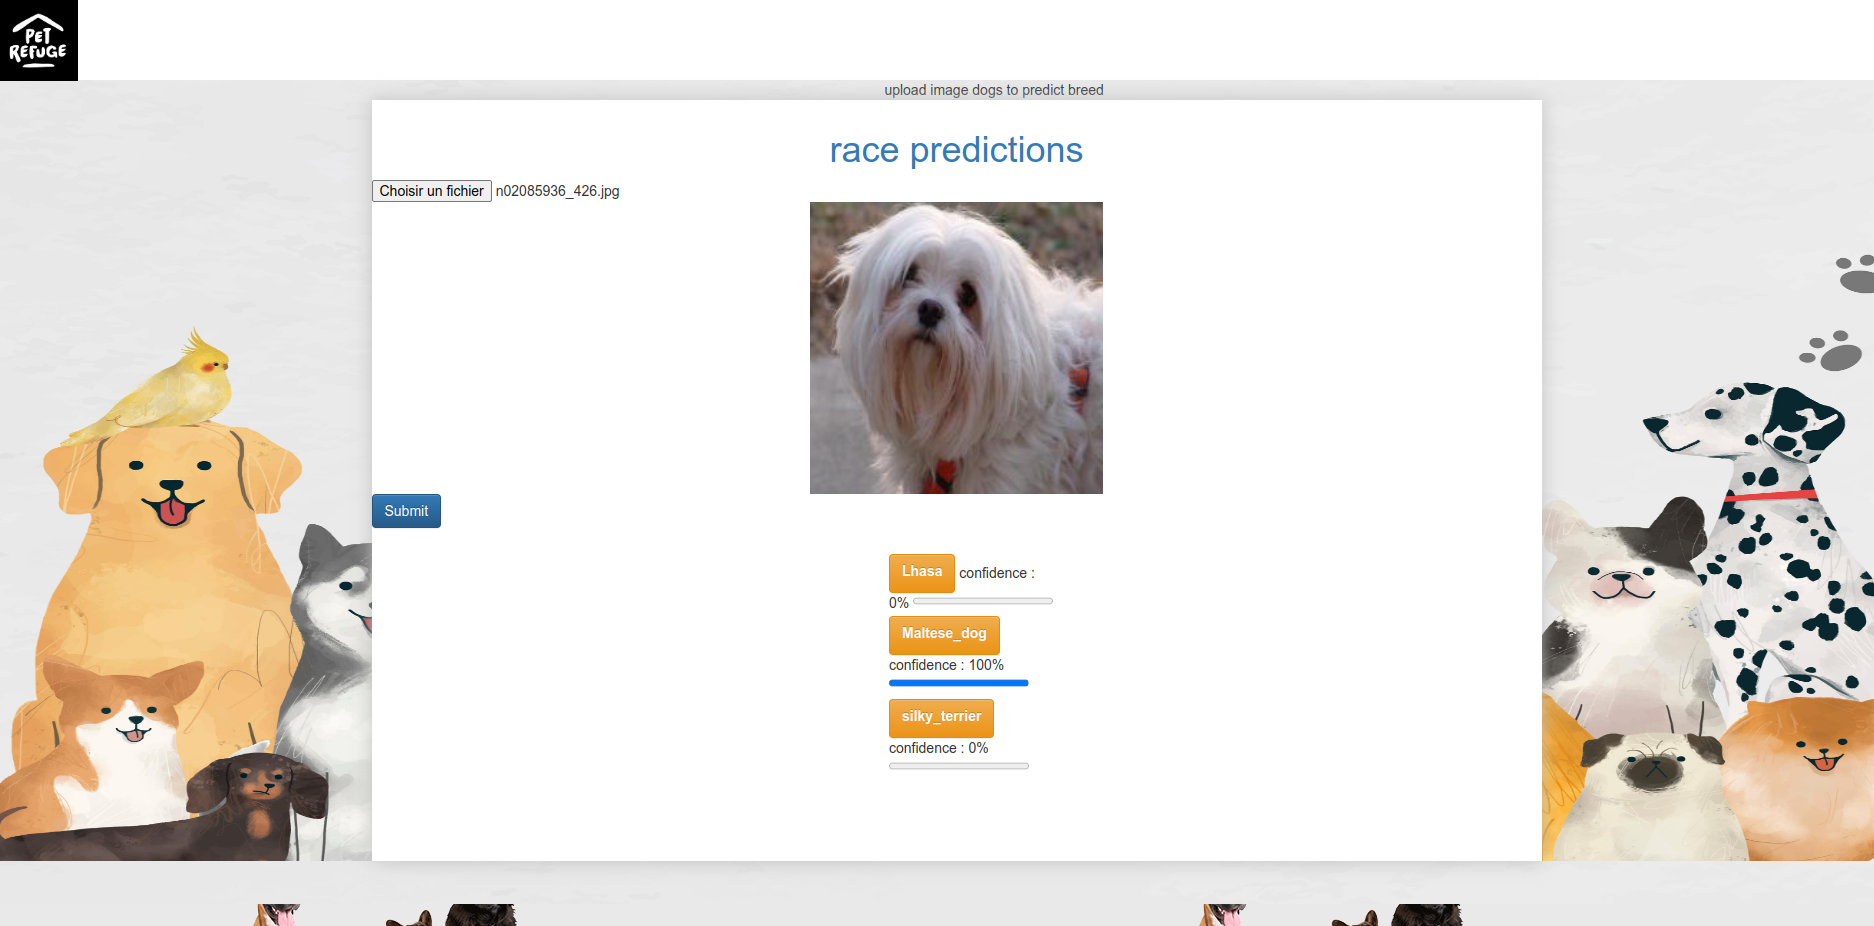




In [3]:
# class_names = list(test_generator.class_indices.keys())
#get the labels class names
import json
# Save it under the form of a json file
# json.dump(class_names, open('./history_and_models/class_names', 'w'))
class_names = json.load(open('../history_and_models/class_names', 'r'))

In [4]:
my_xcept_model = load_model('../history_and_models/my_xcept_model_all_tune.h5', custom_objects={"f1_m": utils.f1_m})

2022-04-19 12:01:04.877533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 12:01:04.939343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 12:01:04.939718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 12:01:04.940832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

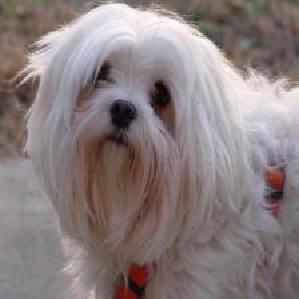

I have 99.47% sure that it belongs to Maltese_dog.
I have 0.51% sure that it belongs to Lhasa.
I have 0.01% sure that it belongs to Shih-Tzu.


In [8]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.xception import preprocess_input


def predict_image(imagePath):
    #load the image
    display(image.load_img(imagePath, target_size = (299, 299)))
    my_image = load_img(imagePath, target_size=(299, 299))
    
    # Convert to RGB
    src = cv.imread(imagePath)
    img = cv.cvtColor(src,cv.COLOR_BGR2RGB)
    dim = (299, 299)
    img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
    # Equalization
    img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
    # Apply non-local means filter on test img
    dst_img = cv.fastNlMeansDenoisingColored(
        src=img_equ,
        dst=None,
        h=15,
        hColor=15,
        templateWindowSize=7,
        searchWindowSize=21)
    my_image = img_to_array(dst_img)

    #preprocess the image
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)

    #make the prediction
    prediction = my_xcept_model.predict(my_image)

    # print([np.round(x) for x in prediction])
    predicted_class=prediction[0].argmax() 
    sorting = (-prediction).argsort()

    # getting the top 2 predictions
    sorted_ = sorting[0][:3]

    for value in sorted_:
        # you can get your classes from the encoder(your_classes = encoder.classes_) 
        # or from a dictionary that you created before.
        # And then we access them with the predicted index.
        predicted_label = class_names[value]

        # just some rounding steps
        prob = (prediction[0][value]) * 100
        prob = "%.2f" % round(prob,2)
        print("I have %s%% sure that it belongs to %s." % (prob, predicted_label))
        
        
        
imagePath =  '../stanford_dog_dataset_tt/cropped/test/Maltese_dog/n02085936_426.jpg'
predict_image(imagePath)        